In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, clear_output

In [5]:
df = pd.read_csv('jv-features.csv')
df['date'] = pd.to_datetime(df2['date'])

df.sample(5)

,date,Weekday,WeekdayNum,AvgHintLength,AvgAnswerLength,NumHints,NumOneWordHints,BlockDensity,OtherPuzAns,NumRepeatedAnswers,NumRepeatedAnswers_Norm,CumTotalAnswers
8195,2016-09-18,Sunday,6,20.564286,5.128571,140,14,18.594104,8412,116,0.000008,104351
5035,2008-01-23,Wednesday,2,18.902778,5.250000,72,13,16.000000,4856,67,0.000012,78870
3249,2002-12-24,Tuesday,1,16.538462,4.897436,78,9,15.111111,6711,66,0.000014,61885
444,1995-03-24,Friday,4,15.694444,5.305556,72,13,15.111111,3561,43,0.000031,18985
4779,2007-05-10,Thursday,3,17.750000,5.026316,76,11,15.111111,5248,66,0.000011,76575


### Number of Reused Answers / Day of Week

Text(0.5, 1.0, 'Number of repeated answers')

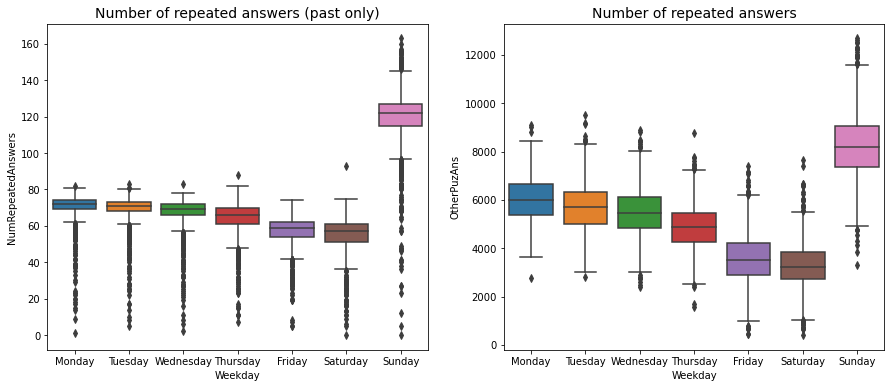

In [13]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

sns.boxplot(data = df, x = "Weekday", y = "NumRepeatedAnswers", ax=ax[0],
           order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

sns.boxplot(data = df, x = "Weekday", y = "OtherPuzAns", ax=ax[1],
           order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

ax[0].set_title("Number of repeated answers (past only)", fontsize = 14)

ax[1].set_title("Number of repeated answers", fontsize = 14)

Caveat: The number of repeated answers (past only) grows as a function of year

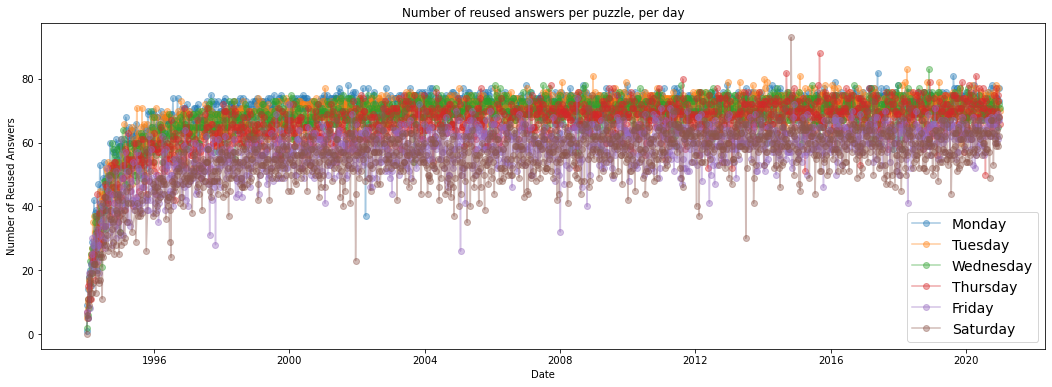

In [56]:
fig, ax = plt.subplots(figsize=(18,6))

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

for day in days:
    ax.plot(df.loc[df.Weekday == day, 'date'], df.loc[df.Weekday == day, 'NumRepeatedAnswers'], 'o-', label=day, alpha=0.4)

ax.legend(fontsize=14)

ax.set_title("Number of reused answers per puzzle, per day")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Reused Answers")
plt.show()

### Number of One-Word hints / Day of Week

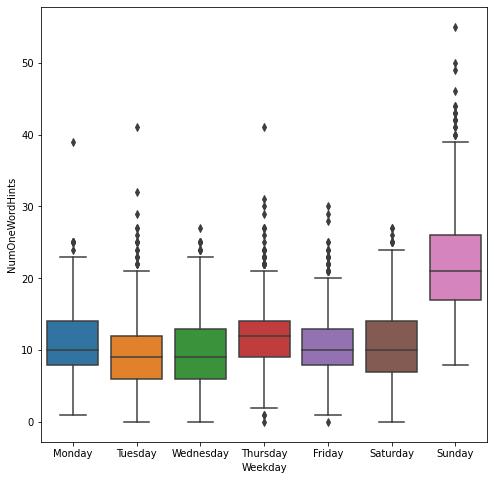

In [21]:
fig, ax = plt.subplots(figsize=(8,8))

sns.boxplot(data = df, x = "Weekday", y = 'NumOneWordHints', ax=ax,
           order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

plt.show()

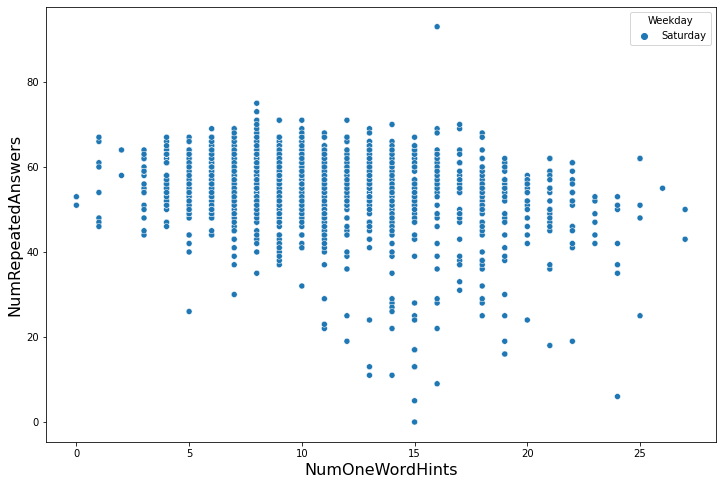

In [50]:
plt.figure(figsize=(12,8))

sns.scatterplot(data = df.loc[df['Weekday'] == 'Saturday'], x = 'NumOneWordHints', y = 'NumRepeatedAnswers', hue = 'Weekday')

plt.xlabel('NumOneWordHints', fontsize=16)
plt.ylabel('NumRepeatedAnswers', fontsize=16)

plt.show()

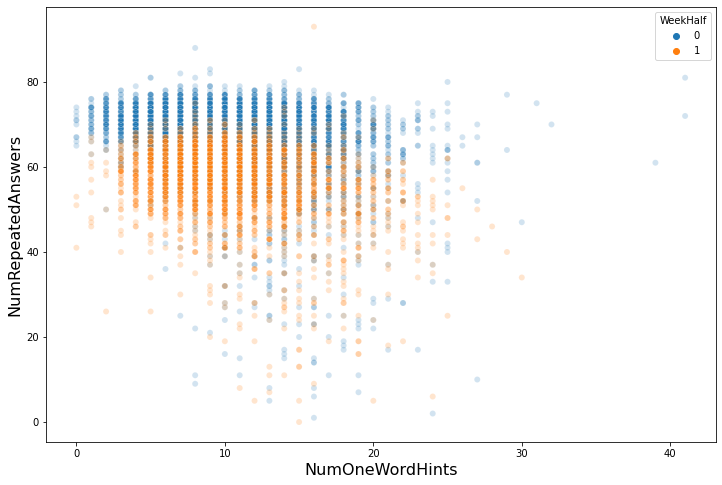

In [63]:
df2 = df.loc[(df.Weekday == 'Monday') | (df.Weekday == 'Tuesday') | (df.Weekday == 'Wednesday') | (df.Weekday == 'Thursday'), ['NumOneWordHints', 'NumRepeatedAnswers']]
df2['WeekHalf'] = 0

df_sunday = df.loc[df.Weekday == 'Sunday']

df3 = df[['NumOneWordHints', 'NumRepeatedAnswers']].drop(df2.index).drop(df_sunday.index)
df3['WeekHalf'] = 1

df_halfweek = pd.concat([df2,df3]).reset_index()

plt.figure(figsize=(12,8))

sns.scatterplot(data = df_halfweek, x = 'NumOneWordHints', y = 'NumRepeatedAnswers', hue = 'WeekHalf', alpha=0.2)

plt.xlabel('NumOneWordHints', fontsize=16)
plt.ylabel('NumRepeatedAnswers', fontsize=16)

plt.show()

In [64]:
df_halfweek

,index,NumOneWordHints,NumRepeatedAnswers,WeekHalf
0,2,16,1,0
1,3,13,5,0
2,4,24,2,0
3,5,19,7,0
4,9,8,9,0
...,...,...,...,...
8356,9737,10,59,1
8357,9743,13,69,1
8358,9744,7,68,1
8359,9750,7,67,1


### Feed Forward Network

In [66]:
from sklearn.model_selection import train_test_split

X = np.array(df_halfweek[['NumOneWordHints', 'NumRepeatedAnswers']])
y = np.array(df_halfweek['WeekHalf'])

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                 test_size = .2,
                                                 random_state = 514,
                                                 shuffle = True,
                                                 stratify = y)

In [127]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier(hidden_layer_sizes=(10,30),max_iter=1000)

mlp.fit(X_train, y_train)

test_score = accuracy_score( y_test, mlp.predict(X_test) )
test_score

0.8230723251643753

In [128]:
x1 = np.linspace(0,50,200);
x2 = np.linspace(0,100,200);
x1v,x2v = np.meshgrid(x1,x2)

X_grid = np.concatenate([x1v.reshape(-1,1),x2v.reshape(-1,1)],axis=1)

pred = mlp.predict(X_grid)

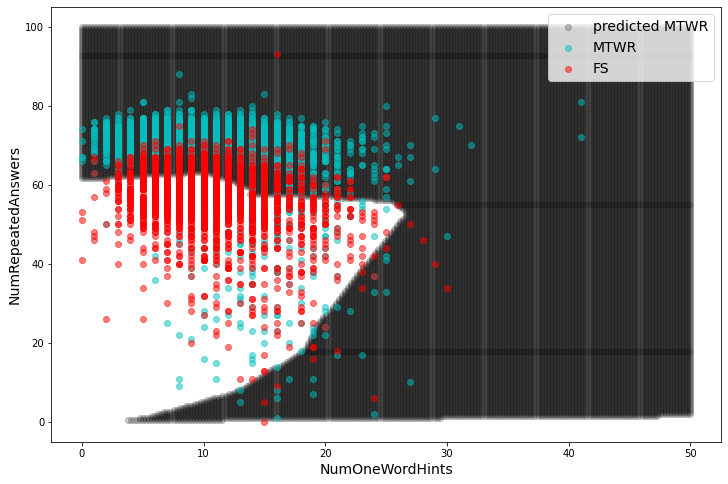

In [129]:
plt.figure(figsize=(12,8))

plt.title("", fontsize=16)

plt.scatter(X_grid[pred == 0,0],X_grid[pred==0,1],c='k',label="predicted MTWR", alpha=0.2)

plt.scatter(X_train[y_train==0,0],X_train[y_train==0,1],c='c',label='MTWR',alpha=.5)
plt.scatter(X_train[y_train==1,0],X_train[y_train==1,1],c='r',label='FS',alpha=.5)

# plt.text(1,-1.75,"Validation Accuracy %.1f" % test_score, fontsize=14)

plt.xlabel("NumOneWordHints", fontsize=14)
plt.ylabel("NumRepeatedAnswers", fontsize=14)

plt.legend(fontsize=14, loc='upper right')

plt.show()

### SVM Classifier

Not finished

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC


In [60]:
# Data

X = np.array(df_halfweek[['NumRepeatedAnswers','NumOneWordHints']])
y = np.array(df_halfweek['WeekHalf'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

sns.scatter